### Predicting future wind speed with prior observations
- Using a linear regression, 
- Using a random forest
### Results
- For reference numerical model skill is MAE ~1.5-1.7 m/s
- Predicting 1-hour in advance, MAE ~ 0.9 m/s, Linear regression and Random Forest similar skill
- Predicting 6-hour in advance, MAE ~ 2.2 m/s, similar between models
- Predicting 12-hour in advance, MAE ~ 2.6-2.7, Random Forest has better skill by ~0.2 m/s

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from scipy import io,signal

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [80]:
def matlab2datetime(matlab_datenum):
    day = datetime.fromordinal(int(matlab_datenum))
    dayfrac = timedelta(days=matlab_datenum%1) - timedelta(days = 366)
    return day + dayfrac

In [81]:
# locations
fobs = '../offline_data/buoy_bulkwave_met_obs_qc.mat'
fpred = '../offline_data/cfsr_buoy_met_pred.mat'

In [82]:
obs = io.loadmat(fobs)
pred = io.loadmat(fpred)
print(pred.keys())

dict_keys(['__header__', '__version__', '__globals__', 'wndspd', 'wnddir', 'time', 'lat', 'lon', 'id'])


In [83]:
# Estimate u,v for pred
pred['u'] = pred['wndspd']*np.cos((90-pred['wnddir']+180)*np.pi/180.0)
pred['v'] = pred['wndspd']*np.sin((90-pred['wnddir']+180)*np.pi/180.0)

In [84]:
# Select just one location for now
loc = 1
print(obs['id'][loc])

[array(['46041'], dtype='<U5')]


In [85]:
# Interp onto prediction time series
ou = np.interp(np.squeeze(pred['time']),np.squeeze(obs['time']),np.squeeze(obs['u'][loc,:]))
pu = pred['u'][:,loc]
ov = np.interp(np.squeeze(pred['time']),np.squeeze(obs['time']),np.squeeze(obs['v'][loc,:]))
pv = pred['v'][:,loc]
t = [matlab2datetime(tt[0]) for tt in pred['time']]
print([ou.shape,pu.shape])

[(272124,), (272124,)]


In [86]:
# Numerical Model prediction error 
u_mae = np.nanmean(np.abs(ou-pu))
v_mae = np.nanmean(np.abs(ov-pv))
print([u_mae,v_mae])

[1.7194398300215474, 1.5261293276756291]


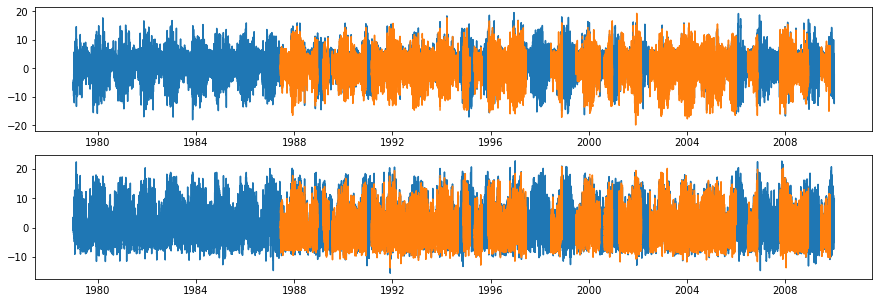

In [87]:
# Plot of data availabitlity
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,5))
ax1.plot(t,pu)
ax1.plot(t,ou)

ax2.plot(t,pv)
ax2.plot(t,ov)

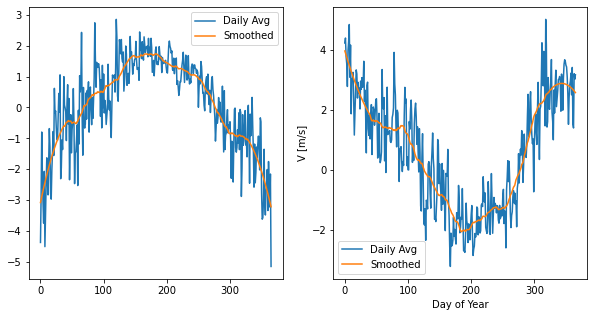

In [88]:
# Generate prior wind speeds, up to X hours back in time using np.roll() like circshift
hr_back = 6
hr_forward = 1
trim = np.max([hr_back,hr_forward])

HU = pd.DataFrame()
HV = pd.DataFrame()
tn = np.array(t.copy())

for ii in range(hr_back):
    col = str(ii)
    HU[col] = np.roll(ou,ii)
    HV[col] = np.roll(ov,ii)

# Create future time step to predict
fu = np.roll(ou,-hr_forward)
fv = np.roll(ov,-hr_forward)

# Create prediction vector for use later
fu_p = np.roll(pu,-hr_forward)
fv_p = np.roll(pv,-hr_forward)
    
# Trim ends
HU = HU[trim:-trim]
HV = HV[trim:-trim]
fu = fu[trim:-trim]
fv = fv[trim:-trim]
tn = tn[trim:-trim]
ov = ov[trim:-trim]
ou = ou[trim:-trim]
fu_p = fu_p[trim:-trim]
fv_p = fv_p[trim:-trim]

# Nan out times with any NaNs
msk1 = HU.isnull()
msk1 = msk1.any(axis=1)
msk2 = np.isnan(fu)
msk = msk1 | msk2
HU[msk] = np.nan
HV[msk] = np.nan
fu[msk] = np.nan
fv[msk] = np.nan

# Remove NaN values
fu = fu[~np.isnan(fu)]
fv = fv[~np.isnan(fv)]
HU = HU.dropna()
HV = HV.dropna()
tn = tn[~msk]
ou = ou[~msk]
ov = ov[~msk]
fu_p = fu_p[~msk]
fv_p = fv_p[~msk]

# Make yearly mean variable
# day of year
doy = np.array([ti.timetuple().tm_yday for ti in tn])-1
uavg = np.zeros(366)
vavg = np.zeros(366)
for dd in range(366):
    msk = (doy == dd)
    uavg[dd] = np.nanmean(ou[msk])
    vavg[dd] = np.nanmean(ov[msk])
    
# Smooth this daily average wind vector
# In future should wrap this before smoothing!

from scipy import signal
uavgs = signal.savgol_filter(uavg, 25*3, 2)
vavgs = signal.savgol_filter(vavg, 25*3, 2)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.plot(uavg,label='Daily Avg')
ax1.plot(uavgs,label='Smoothed')
plt.ylabel('U [m/s]')
ax1.legend()
plt.xlabel('Day of Year')

ax2.plot(vavg,label='Daily Avg')
ax2.plot(vavgs,label='Smoothed')
plt.ylabel('V [m/s]')
ax2.legend()
plt.xlabel('Day of Year')

# Append avg to time series
uavg_t = uavgs[doy]
uavg_t = np.expand_dims(uavg_t,1)
vavg_t = vavgs[doy]
vavg_t = np.expand_dims(vavg_t,1)
HU = np.concatenate((HU,uavg_t),axis=1)
HV = np.concatenate((HU,uavg_t),axis=1)

In [89]:
# train test sets
x_tr, x_te, y_tr, y_te = train_test_split(HU, fu, test_size = 0.25, random_state = 42)

In [90]:
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(x_tr,y_tr)
# Make predictions
y_p = np.squeeze(LR.predict(x_te))
y = np.squeeze(y_te)

r2 = r2_score(y.T,y_p)
mae = np.mean(np.abs(y.T-y_p))
print([r2,mae])
print(LR.coef_)

[0.8789174026555016, 0.9541054759196307]
[ 0.898391    0.04615543  0.01709051 -0.01073275 -0.00730815 -0.01988258
  0.07289525]


In [91]:
from sklearn.ensemble import RandomForestRegressor
import time

start = time.time()
rf = RandomForestRegressor(n_estimators=100, random_state= 40)
rf.fit(x_tr,y_tr)
end = time.time()
print('Finished in {:4.2f} seconds'.format(end - start))


Finished in 94.20 seconds


In [92]:
y_p = rf.predict(x_te)
r2 = r2_score(y.T,y_p)
mae = np.mean(np.abs(y_p-y_te))
print([r2,mae])

[0.8750103222785264, 0.9830204239779696]


### Try adding prediction forecast to regression



In [93]:
HUa = np.concatenate((HU,np.expand_dims(fu_p,1)),axis=1)
x_tr, x_te, y_tr, y_te = train_test_split(HUa, fu, test_size = 0.25, random_state = 42)
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(x_tr,y_tr)
# Make predictions
y_p = np.squeeze(LR.predict(x_te))
y = np.squeeze(y_te)

r2 = r2_score(y.T,y_p)
mae = np.mean(np.abs(y.T-y_p))
print([r2,mae])
print(LR.coef_)

[0.8963155619430376, 0.913546959354225]
[ 0.73499914  0.0216752   0.00694674 -0.00867075 -0.00326752 -0.01507946
  0.02708225  0.2483477 ]


Basically the same skill as with the prediction alone.